# The basic workflow of ML in genomics

1. Data collection
2. Preprocessing
3. Exploratory data analysis (EDA) and visualization
4. Feature extraction and selection
5. Train-test splitting
6. Model training
7. Model evaluation
8. Model interpretation
9. Model deployment
10. Model monitoring

* For model evaluation, one may use many metrics such as MSE, MAE, RMSE, and R-Squared.
* Some model-agnostic interpretability methods include: Local-Interpretable Modelagnostic Explanations (LIME), SHapley Additive ExPlanations (SHAP), and Explanation Summary (ExSUM).

# Use case – Disease prediction

* Goal: Mapping the relationships between individual patients’ sample gene expression values (features) and the target variable (Normal versus Tumor).
* Task: Classification
* Model: Logistic regression
* Data structure: Each row of the data represents a patient sample that consists of gene expressions.

## Data collection

We will use the gene expression data of lung cancer samples and we will try to predict normal versus tumor outcomes.

In [1]:
import pandas as pd

lung1 = pd.read_csv("Data/Lung/GSE87340.csv.zip")
lung2 = pd.read_csv("Data/Lung/GSE60052.csv.zip")
lung3 = pd.read_csv("Data/Lung/GSE40419.csv.zip")
lung4 = pd.read_csv("Data/Lung/GSE37764.csv.zip")
lung_1_4 = pd.concat([lung1, lung2, lung3, lung4])

In [2]:
# Check data
lung_1_4.iloc[:,0:10].head()

,ID,class,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036
0,SRR4296063,Normal,10.728260,4.668142,10.278195,10.184036,8.215333,11.310861,13.178872,11.469473
1,SRR4296064,Tumor,11.332606,2.329988,10.127734,10.167900,8.174060,10.399611,13.208972,11.510862
2,SRR4296065,Normal,9.951182,4.264426,10.288874,10.093258,8.011385,11.814572,14.038661,11.651766
3,SRR4296066,Tumor,12.185680,2.798643,10.178582,10.401606,8.902321,10.294009,13.170466,11.546855
4,SRR4296067,Normal,9.875179,2.922071,10.444479,10.435843,8.692961,12.604934,13.538341,11.733252


## Data preprocessing

### Dealing with missing data

Remove it or impute it.

In [3]:
# Check the amount of missing data in each column
lung_1_4.isna().sum()

ID                 0
class              0
ENSG00000000003    0
ENSG00000000005    0
ENSG00000000419    0
                  ..
ENSG00000285990    0
ENSG00000285991    0
ENSG00000285992    0
ENSG00000285993    0
ENSG00000285994    0
Length: 58737, dtype: int64

In [4]:
# Check the amount of missing data in all columns
lung_1_4.isna().sum().sum()

0

### EDA

Let’s first start by plotting the distribution of samples corresponding to each lung cancer type. We first create a DataFrame of the class column, then calculate the number of rows corresponding to each class, and then reset the index to make it easy for plotting.

In [5]:
df = lung_1_4['class'].value_counts().reset_index()

Text(0, 0.5, 'Class')

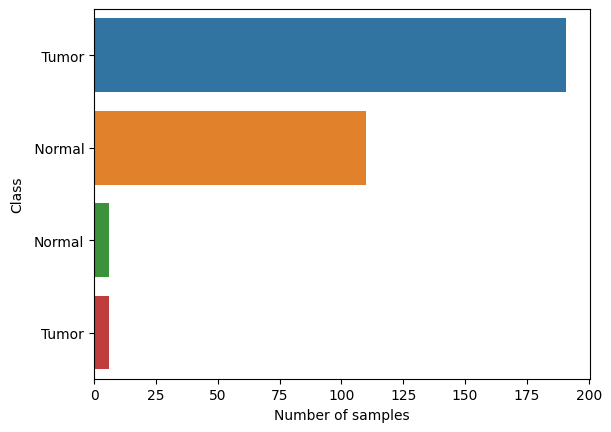

In [6]:
# Visualize the classes on a bar plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x = "class", y = "index", data = df)
plt.xlabel("Number of samples")
plt.ylabel("Class")

We have a problem now. As you can see, there are two types of samples, both of which are classified as Normal and the same for Tumor. Let’s look at the different classes closely and see what’s going on:

In [7]:
set(lung_1_4['class'])

{' Normal', ' Tumor', 'Normal', 'Tumor'}

If you look closely, we notice that there is an extra space in front of the first and second classes. Let’s rename those right away using the following replace method:

Text(0, 0.5, 'Class')

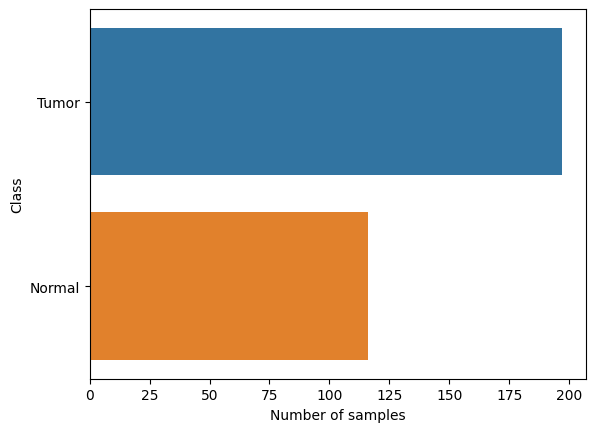

In [8]:
lung_1_4['class'] = lung_1_4['class'].replace(' Normal', 'Normal')
lung_1_4['class'] = lung_1_4['class'].replace(' Tumor', 'Tumor')
df = lung_1_4['class'].value_counts().reset_index()

# Replot
sns.barplot(x = "class", y = "index", data = df)
plt.xlabel("Number of samples")
plt.ylabel("Class")

### Data transformation

Any systematic differences between samples must be corrected before proceeding to the next step. First, we will restrict our dataset to the first 10 columns since it is challenging to visualize all the columns at once in a single boxplot. Then, we convert the data from wide format to long format using the melt method in Pandas:

Text(0, 0.5, 'Expression')

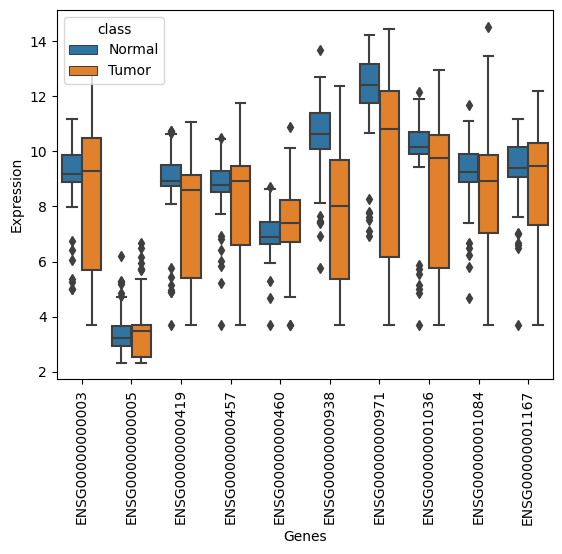

In [9]:
lung_1_4_m = pd.melt(lung_1_4.iloc[:,1:12], id_vars = "class")

# Look at the distribution of expression across selected samples
ax = sns.boxplot(x = "variable" , y = "value", data = lung_1_4_m, hue = "class")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xlabel("Genes")
plt.ylabel("Expression")

Each sample has a somewhat similar distribution of gene expression values except for the first few samples (compare the medians). In addition, the expression values are already normalized and there is no need to normalize this further. So, let’s proceed without normalizing these samples.

## Train-test splitting

In this case, we will split the train and test datasets in the ratio of 75:25.

In [10]:
# Drop the ID and class columns in the dataset, and convert it to a NumPy ndarray
x_data = lung_1_4.drop(['class', 'ID'], axis = 1).values

# Similarly, we will create a NumPy ndarray for the labels
y_data = lung_1_4['class'].values

# Convert the categorical data in the type column to numbers using the ordinal encoding method
classes = lung_1_4['class'].unique().tolist()

import numpy as np
func = lambda x: classes.index(x)
y_data = np.asarray([func(i) for i in y_data], dtype = "float32")
print(y_data[1:10])

[1. 0. 1. 0. 1. 0. 1. 0. 1.]


Here, 0 represents the Normal class, while 1 represents the Tumor class. Now, we are ready to split the data into training and testing.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state = 42, test_size = 0.25, stratify = y_data)

print(f'Training X shape: {X_train.shape}')
print(f'Training Y shape: {y_train.shape}')
print(f'Test X shape: {X_test.shape}')
print(f'Test Y shape: {y_test.shape}')

Training X shape: (234, 58735)
Training Y shape: (234,)
Test X shape: (79, 58735)
Test Y shape: (79,)


## Model training

In [12]:
model_lung1 = LogisticRegression()
model_lung1.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Model evaluation

Now that model has been trained, let’s run the model on one sample of the test data.

In [13]:
pred = model_lung1.predict(X_test[12].reshape(1, -1))
pred

array([1.], dtype=float32)

Do predictions for all samples in the test data:

In [14]:
all_pred_lung = model_lung1.predict(X_test)

Let's calculate the accuracy score:

In [15]:
model_lung1.score(X_test, y_test)

0.9620253164556962

Let’s run a confusion matrix:

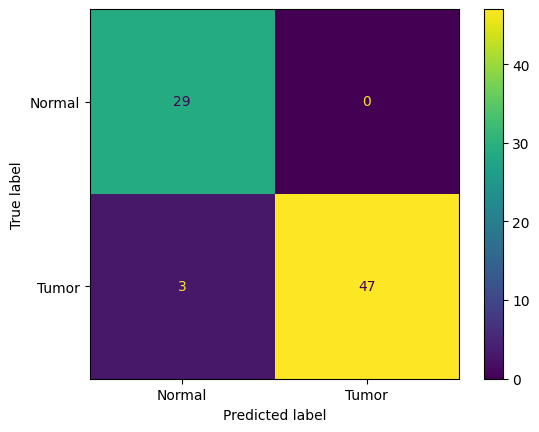

In [16]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, all_pred_lung)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal", 'Tumor'])
disp.plot()
plt.show()

Please note that the cost of misclassifying a sample is high for false negative samples compared to false positive ones because we don’t want to miss any patient that has a tumor.

Now, let's get the classification report:

In [17]:
print(classification_report(y_test, all_pred_lung))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        29
         1.0       1.00      0.94      0.97        50

    accuracy                           0.96        79
   macro avg       0.95      0.97      0.96        79
weighted avg       0.97      0.96      0.96        79

